# VAE Model Testing Framework

In [13]:
from utils.reproducibility import set_deterministic_run, get_deterministic_dataloader

seed = 42
set_deterministic_run(seed=seed)

## 1. Imports

In [2]:
import torch
import numpy as np
import torch.utils
import matplotlib.pyplot as plt
import torch.optim as optim

import utils.visualize
from trainers import UnsupervisedTrainer
import losses
import vae_models
from datasets import get_dataset
from utils.io import find_optimal_num_workers

## 2. Configuration

In [3]:
# --- General Hyperparameters ---
model_name = 'vae_locatello'  # Name of the model architecture file (e.g., 'vae_burgess')
latent_dim = 10
learning_rate = 1e-4
batch_size = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rec_dist = 'bernoulli'  # Reconstruction distribution (e.g., 'bernoulli', 'gaussian')


train_step_unit = 'epoch'  # Unit for training steps ('epoch' or 'iteration')
num_train_steps = 5

# train_step_unit = 'iteration'  # Unit for training steps ('epoch' or 'iteration')
# num_train_steps = int(9e3)  # Number of training steps 

In [4]:
# --- Loss Specific Hyperparameters ---
# Beta VAE
loss_name = 'betavae'      # Type of loss ('betavae', 'annealedvae', 'betatcvae')
loss_kwargs = {
    'beta': 16,
    'rec_dist': rec_dist
               }

In [5]:
# # AnnealedVAE
# loss_name = 'annealedvae'  
# loss_kwargs = {
#     'C_init': 0.0,
#     'C_fin_3dshapes': 25.0,
#     'C_fin_dsprites': 15.0,
#     'gamma_annealed': 100.0,
#     'anneal_steps': 10000,
#     'rec_dist': rec_dist,
# }

In [6]:
# # BetaTCVAE
# loss_name = 'betatcvae'
# loss_kwargs = {
#     'alpha_tc': 1.0,
#     'beta_tc_3dshapes': 6.0,
#     'beta_tc_dsprites': 4.0,
#     'gamma_tc': 1.0,
#     'is_mss': True,
#     'rec_dist': rec_dist
# }

In [7]:
# # Factor VAE

# loss_name = 'factorvae'
# loss_kwargs = {
#     'device': device,
#     'gamma': 6.4,
#     'discr_lr': 5e-5,
#     'discr_betas': (0.5, 0.9),
#     'rec_dist': rec_dist,
# }

## 3. Load Datasets

In [8]:
# Load 3D Shapes
Shapes3D = get_dataset("shapes3d")
shapes3d_dataset = Shapes3D(selected_factors='all', not_selected_factors_index_value=None)
# num_workers_3dshapes = find_optimal_num_workers(shapes3d_dataset, batch_size=batch_size, num_batches_to_test='all')
num_workers_3dshapes = 4

# shapes3d_dataloader = torch.utils.data.DataLoader(shapes3d_dataset, batch_size=batch_size, num_workers=num_workers_3dshapes, shuffle=True, pin_memory=True)
shapes3d_dataloader = get_deterministic_dataloader(dataset=shapes3d_dataset, 
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=num_workers_3dshapes,
                                                   seed=seed,
                                                   pin_memory=True)

print(f"Loaded 3D Shapes dataset with {len(shapes3d_dataset)} samples.")


Loaded 3D Shapes dataset with 480000 samples.


In [9]:

# Load dSprites
Dsprites = get_dataset('dsprites')

dsprites_dataset = Dsprites(selected_factors='all', not_selected_factors_index_value=None)
# num_workers_dsprites = find_optimal_num_workers(dsprites_dataset, batch_size=batch_size, num_batches_to_test='all')
num_workers_dsprites = 7

# dsprites_dataloader = torch.utils.data.DataLoader(dsprites_dataset, batch_size=batch_size, num_workers=num_workers_dsprites, shuffle=True, pin_memory=True)
dsprites_dataloader = get_deterministic_dataloader(dataset=dsprites_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=num_workers_dsprites,
                                                   seed=seed,
                                                   pin_memory=True)

print(f"Loaded dSprites dataset with {len(dsprites_dataset)} samples.")

Loaded dSprites dataset with 737280 samples.


## 4. Setup Model, Loss, and Optimizer

In [10]:
def setup_components(dataset, loss_kwargs):
    """Instantiates model, loss function, and optimizer based on config."""
    img_size = dataset[0][0].shape
    n_data = len(dataset)
    

    # Instantiate Model
    model = vae_models.select(name=model_name, img_size=img_size, latent_dim=latent_dim)

    if loss_name == 'betatcvae':
        loss_kwargs['n_data'] = n_data
    
    loss_fn = losses.select(loss_name, **loss_kwargs)

    # Instantiate Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print(f"--- Setup for {dataset.__class__.__name__} --- ")
    print(f"Model: {model.__class__.__name__}")
    print(f"Loss: {loss_fn.__class__.__name__} (rec_dist={rec_dist}), kwargs={loss_kwargs}")
    print(f"Optimizer: {optimizer.__class__.__name__}")
    print(f"---------------------------")

    return model, loss_fn, optimizer

## 5. Train and Visualize

## 5.1 - 3D Shapes

In [11]:
shapes3d_loss_kwargs =  {
     'beta': 16,
     'rec_dist': rec_dist
               }

In [ ]:
print("\n===== Training on 3D Shapes =====")
model_3dshapes, loss_fn_3dshapes, optimizer_3dshapes = setup_components(shapes3d_dataset, shapes3d_loss_kwargs)

trainer_3dshapes = UnsupervisedTrainer(model=model_3dshapes,
                                      loss_fn=loss_fn_3dshapes,
                                      lr_scheduler=None,
                                      optimizer=optimizer_3dshapes,
                                      device=device,
                                      train_step_unit=train_step_unit,
                                      )

trainer_3dshapes.train(shapes3d_dataloader, max_steps=num_train_steps)


===== Training on 3D Shapes =====
--- Setup for Shapes3D --- 
Model: Model
Loss: Loss (rec_dist=bernoulli), kwargs={'beta': 16, 'rec_dist': 'bernoulli'}
Optimizer: Adam
---------------------------


[{'loss': 4481.198466048177,
  'rec_loss': 4235.089198177084,
  'kl_loss': 15.381829216080904,
  'epoch': 1},
 {'loss': 4022.5255199869794,
  'rec_loss': 3754.886118717448,
  'kl_loss': 16.72746260350545,
  'epoch': 2},
 {'loss': 3968.0102971028646,
  'rec_loss': 3701.58258359375,
  'kl_loss': 16.651731979115805,
  'epoch': 3},
 {'loss': 3936.785772949219,
  'rec_loss': 3671.9779036783852,
  'kl_loss': 16.550491694132486,
  'epoch': 4},
 {'loss': 3916.213226888021,
  'rec_loss': 3652.898659667969,
  'kl_loss': 16.45716055437724,
  'epoch': 5}]


===== Visualizing 3D Shapes Results =====
Plotting random reconstructions...


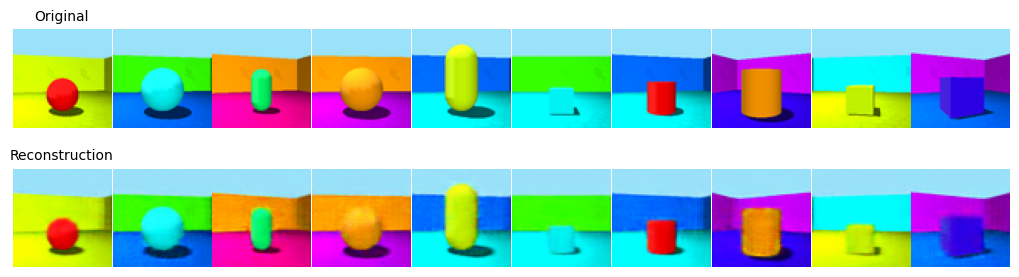

Plotting reconstructions from specific indices...


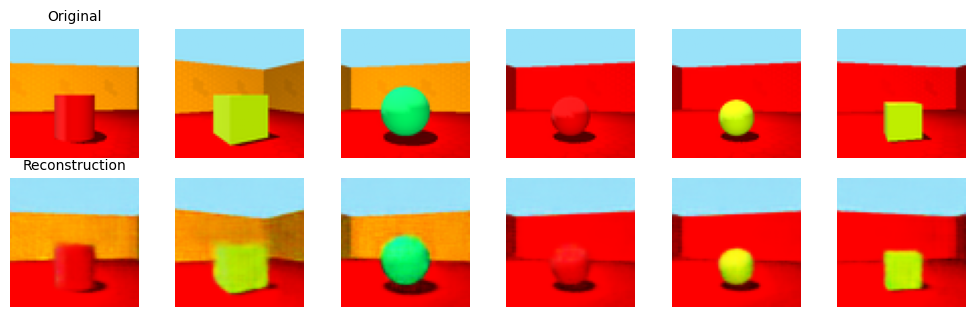

Plotting latent traversals...


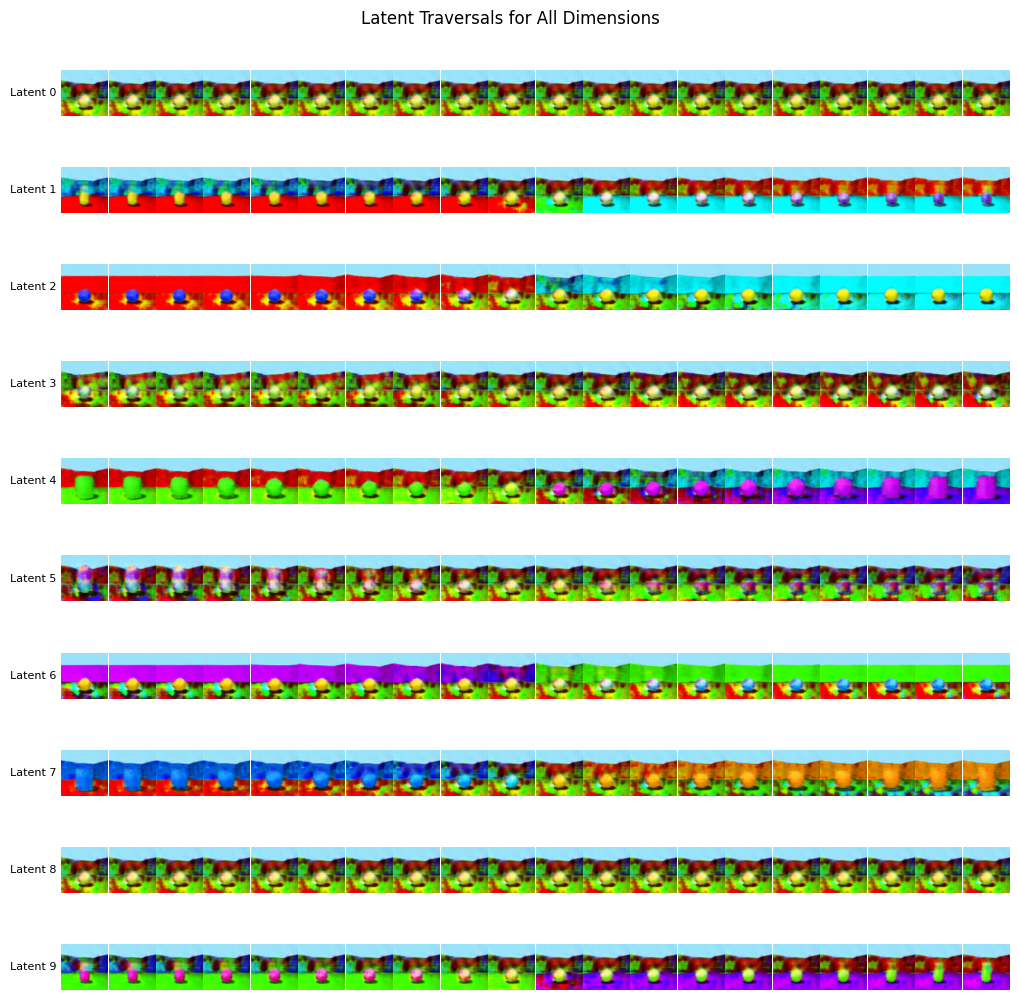

In [ ]:
print("\n===== Visualizing 3D Shapes Results =====")
visualizer_3dshapes = utils.visualize.Visualizer(vae_model=model_3dshapes, dataset=shapes3d_dataset)

print("Plotting random reconstructions...")
visualizer_3dshapes.plot_random_reconstructions(10, mode='mean')
plt.show()

print("Plotting reconstructions from specific indices...")
indices_3dshapes = [5000, 6000, 7000, 100, 1000, 1024] # Example indices
visualizer_3dshapes.plot_reconstructions_sub_dataset(indices_3dshapes, mode='mean')
plt.show()

print("Plotting latent traversals...")
visualizer_3dshapes.plot_all_latent_traversals(num_samples=20)
plt.show()

## 5.2. Train and Visualize: dSprites

### Loss args

In [ ]:
# Beta VAE
loss_kwargs_beta_vae_dsprites =  {
    'beta': 4,
    'rec_dist': rec_dist
               }

In [ ]:
# Annealed VAE


In [ ]:
# Beta TC-VAE


In [ ]:
# Factor VAE


### Train

In [ ]:
print("\n===== Training on dSprites =====")
model_dsprites, loss_fn_dsprites, optimizer_dsprites = setup_components(dsprites_dataset, loss_kwargs_beta_vae_dsprites)

trainer_dsprites = UnsupervisedTrainer(model=model_dsprites,
                                     loss_fn=loss_fn_dsprites,
                                     scheduler=None,
                                     optimizer=optimizer_dsprites,
                                     device=device)

trainer_dsprites.train(dsprites_dataloader, num_epochs=num_epochs)


===== Training on dSprites =====
--- Setup for DSprites --- 
Model: Model
Loss: Loss (rec_dist=bernoulli), kwargs={'beta': 4, 'rec_dist': 'bernoulli'}
Optimizer: Adam
---------------------------



===== Visualizing dSprites Results =====
Plotting random reconstructions...


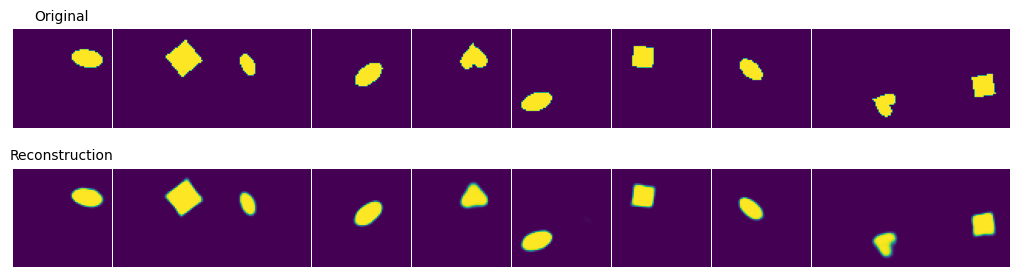

Plotting reconstructions from specific indices...


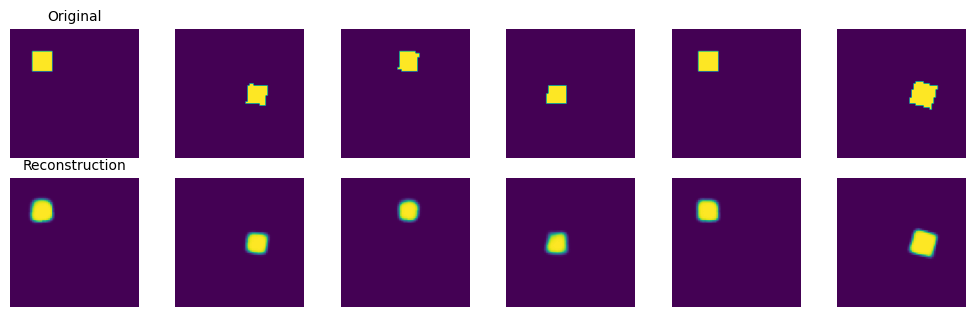

Plotting latent traversals...


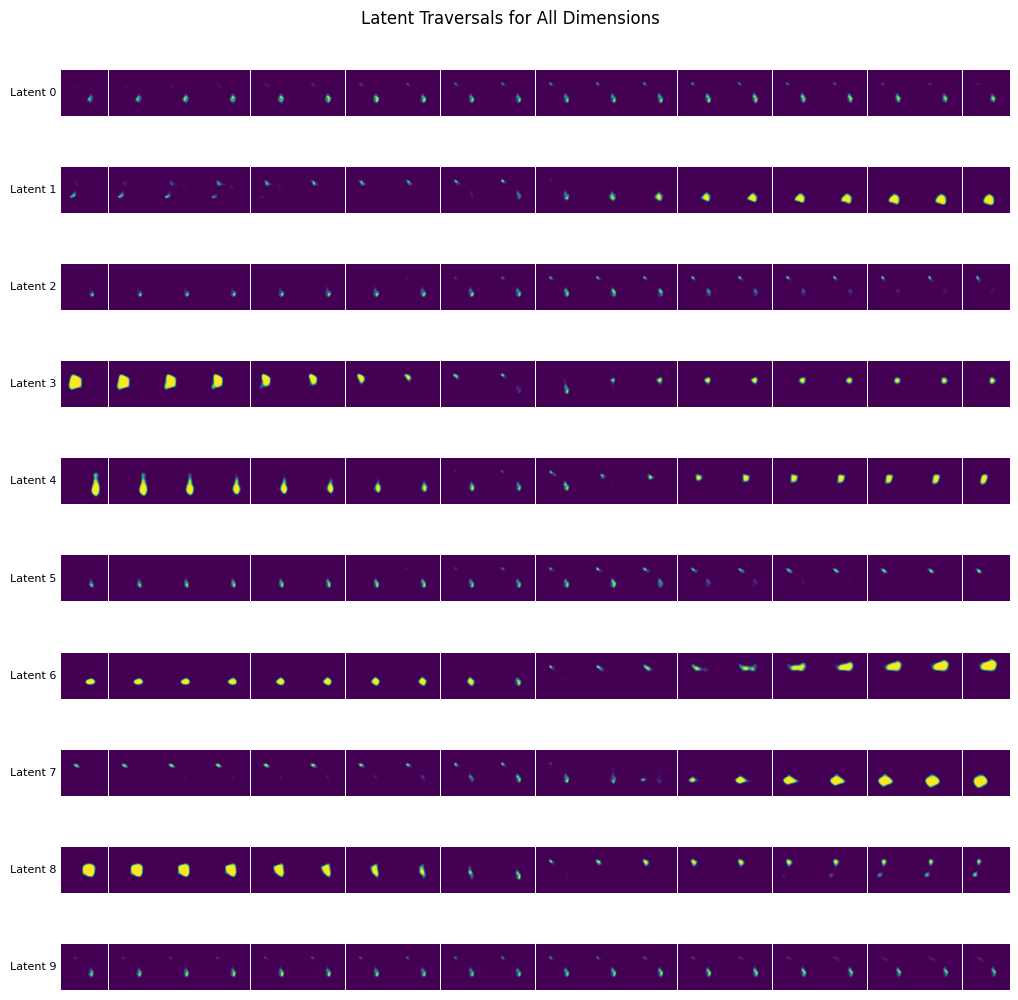

In [ ]:
print("\n===== Visualizing dSprites Results =====")
visualizer_dsprites = utils.visualize.Visualizer(vae_model=model_dsprites, dataset=dsprites_dataset)

print("Plotting random reconstructions...")
visualizer_dsprites.plot_random_reconstructions(10, mode='mean')
plt.show()

print("Plotting reconstructions from specific indices...")
indices_dsprites = [0, 10000, 20000, 30000, 40000, 50000] # Example indices
visualizer_dsprites.plot_reconstructions_sub_dataset(indices_dsprites, mode='mean')
plt.show()

print("Plotting latent traversals...")
visualizer_dsprites.plot_all_latent_traversals(num_samples=20)
plt.show()